<img src="https://www.earth.ac.cr/es">

# Plantilla para el gráfico de densogramas de uniformidad de Riego 

## Jupypter Notebook by Python 3.9.4

El presente Notebook permité, a partir de los datos de campo de la prueba de CAN-CAN, deteminar los siguientes indicadores de riego:
- CU Coefficient Uniformity
- DU Coefficient Distribution (25% lowest)
- SC Schedualing Coefficient 

De igual forma permité contruir los gráficos de interpolación (desogramas de riego)

## Preparado por:
Prof. Gregory Guevara Laboratorio de Fertirriego Univeridad Earth, Mayo 2021 gguevara@earth.ac.cr



### Bibliotecas utilizadas e importación de Datos:

In [1]:

import pykrige
import pykrige.kriging_tools as kt #herramientas para exportar e importar archivos .asc con biblioteca PyKrige
from pykrige.ok import OrdinaryKriging #Kriging Ordinario con PyKrige
import pandas as pd #biblioteca de manipulación y análisis de datos
import numpy as np #biblioteca de funciones matemáticas

import matplotlib.pyplot as plt #biblioteca de generación de gráficos
import matplotlib
import matplotlib.cm as cm
from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
from mpl_toolkits.mplot3d import Axes3D

#open data frame de excel 
carpeta = "C:/Users/gguevara/OneDrive - Universidad EARTH/python-analysis/uniformidad/" #carpeta contenedora del archivo de inicio
archivo = "uniformidad_python.xlsx" #dataset prueba uniformidad
df = pd.read_excel(carpeta + archivo) #rutina de lectura del archivo con Pandas

#limpieza y acomodo de los datos
df= df.dropna() # me permite borrar valores vacios 

#ordenado de los datos de menor a mayor
df=df.sort_values('caudal')




### Calculo de indicadores estadisticos CU/DU/SC

In [ ]:

minimo=df["caudal"].min()
maximo=df["caudal"].max()
media=df["caudal"].mean()
desviacion=df["caudal"].std()

print("el valor mínimo es= "+str(minimo))
print("el valor máximo es= "+str(maximo))
print("el valor media es= "+str(media))
print("el valor desviación estandar es= "+str(desviacion))

#calcular Coeficiente uniformidad 
def xi(caudal): 
    xi=abs(caudal-media)
    return xi
df["xi"]=df["caudal"].apply(xi)
n=len(df)
suma_xi=np.sum(df["xi"])
CU=round((1-suma_xi/media/n)*100,3)

#calcular Coeficiente distribución en el cuarto inferior 
largo=round(n*0.25)
df_25=df[0:largo]
media_25=df_25["caudal"].mean()
DU=round(media_25/media*100,3)

#calcular Coeficiente SC o de factor de calendarización 

SC=round((minimo/media)**-1,2)

#Salida 
print("************************************************")
print("los indicadores de uniformidad son los siguentes")
print("CU= "+str(CU)+"%")
print("DU= "+str(DU)+"%")
print("SC= "+str(SC))
print("************************************************")

print (df)

el valor mínimo es= 0.9461999999999999
el valor máximo es= 1.178
el valor media es= 1.00094375
el valor desviación estandar es= 0.06354913027204488
************************************************
los indicadores de uniformidad son los siguentes
CU= 95.299%
DU= 95.195%
SC= 1.06
************************************************
    punto  x  y   ml  caudal        xi
0       1  1  1  498  0.9462  0.054744
6       7  2  3  502  0.9538  0.047144
8       9  3  1  502  0.9538  0.047144
10     11  3  3  504  0.9576  0.043344
13     14  4  2  507  0.9633  0.037644
12     13  4  1  508  0.9652  0.035744
4       5  2  1  510  0.9690  0.031944
9      10  3  2  510  0.9690  0.031944
5       6  2  2  512  0.9728  0.028144
1       2  1  2  517  0.9823  0.018644
14     15  4  3  533  1.0127  0.011756
3       4  1  4  536  1.0184  0.017456
7       8  2  4  536  1.0184  0.017456
2       3  1  3  552  1.0488  0.047856
11     12  3  4  582  1.1058  0.104856
15     16  4  4  620  1.1780  0.177056


### Procedimientos para correger las interpolaciones 

In [ ]:
#variables convertidas a ndarray: Matriz Numpy

x = np.array([df["x"]])
y = np.array([df["y"]])
z = np.array([df["caudal"]])
punto=np.array([df["punto"]])
punto.astype('str')
z1=z
print("varianza Caudal: ",round(z.var(), 4)) #Referencia para el variograma.ica (en un próximo notebook se revisaran variogramas direccionales para el caso de anisotropía).



varianza Caudal:  0.0038


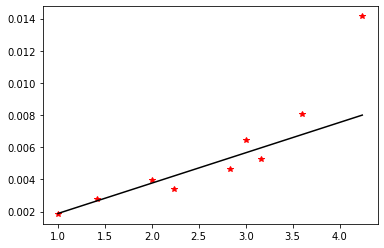

(100, 100)

In [ ]:
OK = OrdinaryKriging(x,y,z, variogram_model='spherical', nlags=20, 
                     variogram_parameters= {'sill': 0.22, 'range': 175, 'nugget': 0}, enable_plotting=True, 
                    coordinates_type='euclidean')

#Creando el grid set: Cuadricula que discretizará el área
grid_x = np.linspace(0, 5, num=100, endpoint=False) #Se crean 50 celdas de 0.1 metros desde min() - max() del eje X.
grid_y = np.linspace(0, 5, num=100, endpoint=False) #Se crean 50 celdas de 0.1 metros desde min() - max() del eje Y.

#Kriging Ordinario (z) y varianza de estimación (ss):
z, ss = OK.execute('grid', grid_x, grid_y) # z caudal y ss la varianza


#Guardando archivo ASCII:
kt.write_asc_grid(grid_x, grid_y, z, filename="kriging_ordinario.asc") #Kriging Ordinario en forma de matriz
kt.write_asc_grid(grid_x, grid_y, ss, filename="kriging_ordinario_var.asc") #Varianza de estimación en forma de matriz
asc = pd.read_csv(r'C:/Users/gguevara/OneDrive - Universidad EARTH/python-analysis/uniformidad\kriging_ordinario.asc', header=None, skiprows=7, sep="\s+") 
z2 = np.array(asc) #Conversión pandas dataframe a ndarray
asc.shape #comprobar que sean 100 filas y 100 columnas


## Desogramas 

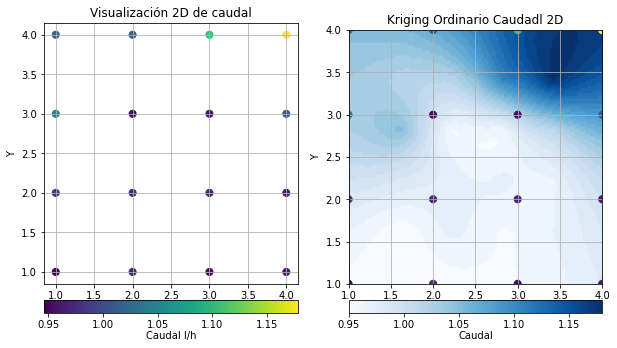

In [ ]:


#Ploteo de los mapas de Kriging:


fig = plt.figure(figsize=(10,6))

plot1=fig.add_subplot(121)
marker_size = 50
a = plt.scatter(x, y, marker_size, z1) #el estilo gist_rainbow es algo mas convencional.
plt.grid(True)
cbar = fig.colorbar(a, orientation='horizontal', pad=0.05)
cbar.set_label("Caudal l/h", labelpad=+1)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Visualización 2D de caudal")
#for i, txt in enumerate(punto):
#    c=plt.annotate(txt, x[i], y[i], fontsize=10, color = "r", style = "italic", weight = "light")

plot2 = fig.add_subplot(122)
b = plt.imshow(z2, cmap=plt.cm.Blues, extent=[1,4,1,4]) #gist_rainbow
a = plt.scatter(x, y, marker_size, z1) #el estilo gist_rainbow es algo mas convencional
plt.grid(True)
cbar = fig.colorbar(b, orientation='horizontal',pad=0.05)
cbar.set_label("Caudal", labelpad=+1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Kriging Ordinario Caudadl 2D')

plt.show ()


<ipython-input-6-cc61b964ecdc>:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax=Axes3D(fig)


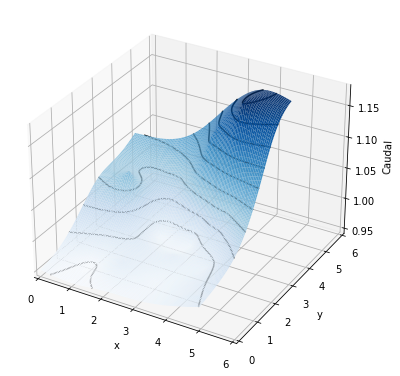

In [ ]:
fig =plt.figure (figsize=(5,5))
ax=Axes3D(fig)
grid_x,grid_y=np.meshgrid(grid_x,grid_y)
ax.plot_surface(grid_x,grid_y,z,rstride=1,cstride=1,cmap=plt.cm.Blues,lw=0.5)
#ax.contour(grid_x,grid_y,z,10,cmap=plt.cm.Blues,linestyles='solid',offset=-1)
ax.contour(grid_x,grid_y,z,10,colors='k',linestyles='solid')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.ylim(0,6)
plt.xlim(0,6)
ax.set_zlabel('Caudal')
plt.show()




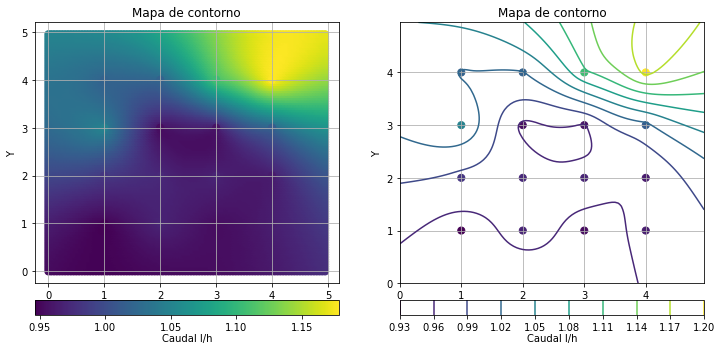

In [ ]:
fig = plt.figure(figsize=(12,6))

bx = fig.add_subplot(121)
d = bx.scatter(grid_x,grid_y,marker_size,z)
a = plt.scatter(x, y, marker_size, z1) #etiqueta de puntos 
cbar = fig.colorbar(d, orientation='horizontal', pad=0.05)
cbar.set_label("Caudal l/h", labelpad=+1)
plt.grid(True)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Mapa de contorno')

bx = fig.add_subplot(122)
a = plt.scatter(x, y, marker_size, z1) #etiqueta de puntos 
d = bx.contour(grid_x,grid_y,z)
cbar = fig.colorbar(d, orientation='horizontal', pad=0.05)
cbar.set_label("Caudal l/h", labelpad=+1)
plt.grid(True)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Mapa de contorno')
plt.show()